In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from sklearn.metrics import confusion_matrix
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
data = scipy.io.loadmat('spamTrain.mat')
holdout = scipy.io.loadmat('spamTest.mat')

In [46]:
X_train = pd.DataFrame(data['X'])
y_train = pd.Series(data['y'].transpose()[0])

hld_X = pd.DataFrame(holdout['Xtest'])
hld_y = pd.Series(holdout['ytest'].transpose()[0])

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [57]:
def plot_roc(hld_y, pred_proba_holdout, auc_score_hld):
    fpr, tpr, thresholds = roc_curve(hld_y, pred_proba_holdout)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='ROC curve holdout (area = %0.2f)' % auc_score_hld, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc="lower right")
    plt.show()

### Логистическая регрессия

In [44]:
param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.01, 0.1, 1]
            }

grid_log = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid , scoring = 'roc_auc')
grid_log.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

##### ROC Curve

roc auc score holdout: 0.9978980557015239


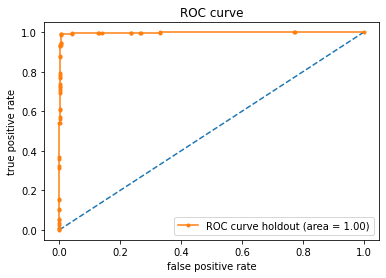

In [69]:
pred_proba_holdout = grid_log.best_estimator_.predict_proba(hld_X)[:, 1]
auc_score_hld = roc_auc_score(hld_y, pred_proba_holdout)

print('roc auc score holdout:', auc_score_hld)

plot_roc(hld_y, pred_proba_holdout, auc_score_hld)

##### Confusion matrix

In [68]:
confusion_matrix(hld_y, grid_log.best_estimator_.predict(hld_X))

array([[688,   4],
       [  2, 306]])

### Дерево решений

In [74]:
param_grid = {
            'max_depth': range(1, 12, 5), 
            'min_samples_split': range(2, 10, 5)
            }

grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid , scoring = 'roc_auc')
grid_dt.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 12, 5),
                         'min_samples_split': range(2, 10, 5)},
             scoring='roc_auc')

##### ROC Curve

roc auc score holdout: 0.9126684370542753


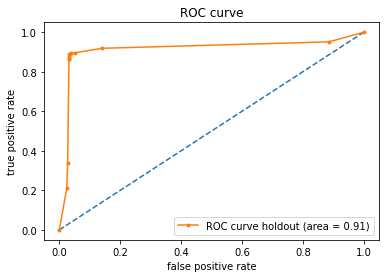

In [75]:
pred_proba_holdout = grid_dt.best_estimator_.predict_proba(hld_X)[:, 1]
auc_score_hld = roc_auc_score(hld_y, pred_proba_holdout)

print('roc auc score holdout:', auc_score_hld)

plot_roc(hld_y, pred_proba_holdout, auc_score_hld)

##### Confusion matrix

In [76]:
confusion_matrix(hld_y, grid_dt.best_estimator_.predict(hld_X))

array([[668,  24],
       [ 34, 274]])

### XGBoost

In [77]:
param_grid = { 
            'n_estimators': range(100, 400, 100)
            }

grid_xgb = GridSearchCV(estimator = XGBClassifier(max_depth=3), param_grid = param_grid , scoring = 'roc_auc')
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=N

##### ROC Curve

roc auc score holdout: 0.9989068012911944


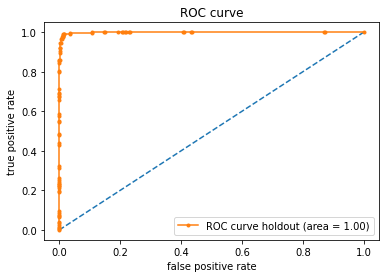

In [78]:
pred_proba_holdout = grid_xgb.best_estimator_.predict_proba(hld_X)[:, 1]
auc_score_hld = roc_auc_score(hld_y, pred_proba_holdout)

print('roc auc score holdout:', auc_score_hld)

plot_roc(hld_y, pred_proba_holdout, auc_score_hld)

##### Confusion matrix

In [79]:
confusion_matrix(hld_y, grid_xgb.best_estimator_.predict(hld_X))

array([[684,   8],
       [  8, 300]])

##### По результатам анализа несложно заключить, что эффективнее работает алгоритм XGBoostClassifier

### NLTK preprocessing

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pymorphy2

In [135]:
text = 'Профессия архитектора тесно тесный связана с изменениями в обществе и, соответственно, подчинена продолжающемуся обсуждению изменяющихся требований к проектированию и строительству. Факторы, которые влияют на это, включают включать технологические разработки разработка, изменения изменению в обществе и изменения процессов организации и осуществления строительства городов и зданий. Сегодня архитекторы нуждаются в комбинации технических, артистических и эстетических, социологических, организационных и экономических навыков. В идеале архитектор - компетентный партнер во всех аспектах проекта, представляя интересы клиентов с одной стороны и общества и сообщества - с другой. Но выше определенного размера проекта отдельный архитектор неспособен принять ответственность за все задачи старых квалифицированных строителей.'

In [136]:
text

'Профессия архитектора тесно тесный связана с изменениями в обществе и, соответственно, подчинена продолжающемуся обсуждению изменяющихся требований к проектированию и строительству. Факторы, которые влияют на это, включают включать технологические разработки разработка, изменения изменению в обществе и изменения процессов организации и осуществления строительства городов и зданий. Сегодня архитекторы нуждаются в комбинации технических, артистических и эстетических, социологических, организационных и экономических навыков. В идеале архитектор - компетентный партнер во всех аспектах проекта, представляя интересы клиентов с одной стороны и общества и сообщества - с другой. Но выше определенного размера проекта отдельный архитектор неспособен принять ответственность за все задачи старых квалифицированных строителей.'

In [137]:
sent_tokenize(text, language='russian')

['Профессия архитектора тесно тесный связана с изменениями в обществе и, соответственно, подчинена продолжающемуся обсуждению изменяющихся требований к проектированию и строительству.',
 'Факторы, которые влияют на это, включают включать технологические разработки разработка, изменения изменению в обществе и изменения процессов организации и осуществления строительства городов и зданий.',
 'Сегодня архитекторы нуждаются в комбинации технических, артистических и эстетических, социологических, организационных и экономических навыков.',
 'В идеале архитектор - компетентный партнер во всех аспектах проекта, представляя интересы клиентов с одной стороны и общества и сообщества - с другой.',
 'Но выше определенного размера проекта отдельный архитектор неспособен принять ответственность за все задачи старых квалифицированных строителей.']

##### Стоп слова и токенизвация

In [138]:
tokens = word_tokenize(text, language='russian')
stop_words = stopwords.words('russian')

print('До фильтрации:', len(tokens))

filtered_tokens = set()
for token in tokens:
    if token not in stop_words:
        filtered_tokens.add(token)

print('После фильтрации:', len(filtered_tokens))

До фильтрации: 111
После фильтрации: 72


##### Стэмминг:

In [139]:
snowball = SnowballStemmer(language='russian')
print(snowball.stem('Хочу'))
print(snowball.stem('Хотеть'))

хоч
хотет


Не везде хорошо работает простое обрубание (по собственному алгоритму)

##### Лемматизация:

In [140]:
 morph = pymorphy2.MorphAnalyzer()

In [141]:
print(morph.parse('Хочу')[0].normal_form)
print(morph.parse('Хотеть')[0].normal_form)

хотеть
хотеть


Работает, как надо, приводит к нормальной форме

In [149]:
print('До леммитизации:', len(filtered_tokens))

lemm_tokens = set()
for token in filtered_tokens:
    lemm_tokens.add(morph.parse(token)[0].normal_form)

print('После леммитизации:', len(lemm_tokens))

До леммитизации: 72
После леммитизации: 64


In [172]:
df = pd.DataFrame(columns=lemm_tokens)

In [191]:
df

,тесный,профессия,клиент,разработка,обсуждение,продолжаться,представлять,соответственно,неспособный,строитель,...,принять,навык,фактор,процесс,но,.,один,квалифицировать,который,ответственность


In [185]:
text_example_1 = 'Какой-то текст Профессия проекта аспектах представляя представляя'
text_example_2= 'текст идеале проекта нуждаются соответственно неспособен'

corpus = [text_example_1, text_example_2]

In [175]:
def prep(text):
    tokens = word_tokenize(text, language='russian')
    stop_words = stopwords.words('russian')

    filtered_tokens = set()
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.add(token)
            
    morph = pymorphy2.MorphAnalyzer()
    
    lemm_tokens = set()
    for token in filtered_tokens:
        lemm_tokens.add(morph.parse(token)[0].normal_form)
        
    return lemm_tokens

In [186]:
print(prep(text_example_1))
print(prep(text_example_2))

{'профессия', 'какой-то', 'представлять', 'проект', 'текст', 'аспект'}
{'идеал', 'проект', 'соответственно', 'неспособный', 'текст', 'нуждаться'}


In [194]:
wordfreq = dict.fromkeys(lemm_tokens, 0)
for sentence in corpus:
    tokens = prep(sentence)
    for token in tokens:
        if token in wordfreq.keys():
            wordfreq[token] += 1
    df = df.append(wordfreq, ignore_index=True)
    wordfreq = dict.fromkeys(lemm_tokens, 0)

In [196]:
df

,тесный,профессия,клиент,разработка,обсуждение,продолжаться,представлять,соответственно,неспособный,строитель,...,принять,навык,фактор,процесс,но,.,один,квалифицировать,который,ответственность
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Аналогично сделать для реальных данных и обучить модель

In [197]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/EvteevIS/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downlo

True